In [2]:
import os
import pandas as pd
import torch
from datasets import Dataset
from PIL import Image
from torchvision import transforms
from transformers import CLIPTokenizer
from diffusers import StableDiffusionPipeline, DDPMScheduler, UNet2DConditionModel, AutoencoderKL
from peft import LoraConfig
from accelerate import Accelerator
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

In [3]:
# Configuration
image_dir = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized/"  # change this
csv_path = "/kaggle/input/image-text-pairs/image_text_pairs.csv"
pretrained_model = "sd-legacy/stable-diffusion-v1-5"
output_dir = "/kaggle/input/sd-lora-output/pytorch/default/1/sd-lora-output"
resolution = 128
batch_size = 4
epochs = 20
lr = 5e-5
rank = 8

In [4]:
# === Load CSV into HF dataset ===
df = pd.read_csv(csv_path)
df["image"] = df["filename"].apply(lambda x: os.path.join(image_dir, x))

# Split the dataframe
train_df, test_df = train_test_split(df[["image", "impression"]], test_size=0.2, random_state=42)

# Create Hugging Face Datasets
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True))
})

In [5]:
from datasets import load_from_disk
import os

# === Constants ===
preprocessed_path = "/kaggle/working/preprocessed_dataset"  # path to save/load preprocessed dataset

# === Preprocess Only If Not Already Saved ===
if os.path.exists(preprocessed_path):
    print("🔁 Loading preprocessed dataset from disk...")
    dataset = load_from_disk(preprocessed_path)
else:
    print("⚙️  Preprocessing dataset...")
    transform = transforms.Compose([
        transforms.Resize(resolution),
        transforms.CenterCrop(resolution),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])
   

    def preprocess(example):
        image = Image.open(example["image"]).convert("RGB")
        pixel_tensor = transform(image)

        return {
            "pixel_values": pixel_tensor,
            "raw_text": example["impression"],  # Keep raw text for later tokenization
        }

    dataset = dataset.map(preprocess)

    print("💾 Saving preprocessed dataset to disk...")
    dataset.save_to_disk(preprocessed_path)



🔁 Loading preprocessed dataset from disk...


In [6]:
import torch

x = dataset["train"][0]["pixel_values"]
x_tensor = torch.tensor(x)
print(x_tensor.shape)

torch.Size([3, 128, 128])


In [7]:
# === Collate Function ===
def collate_fn(batch):
    pixel_values = torch.stack([
        x["pixel_values"] if isinstance(x["pixel_values"], torch.Tensor) else torch.tensor(x["pixel_values"])
        for x in batch
    ])
    
    raw_texts = [x["raw_text"] for x in batch]  # Keep as list of strings

    return {
        "pixel_values": pixel_values,
        "raw_texts": raw_texts,  # Will tokenize later
    }

In [8]:
# === Dataloaders ===
batch_size = 4  # Modify as needed
train_dataloader = DataLoader(dataset["train"], batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(dataset["test"], batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [9]:
!pip install torchmetrics[image]

In [10]:
!pip install torch-fidelity

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/loaders/unet.py:212: FutureWarning: `load_attn_procs` is deprecated and will be removed in version 0.40.0. Using the `load_attn_procs()` method has been deprecated and will be removed in a future version. Please use `load_lora_adapter()`.
  deprecate("load_attn_procs", "0.40.0", deprecation_message)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

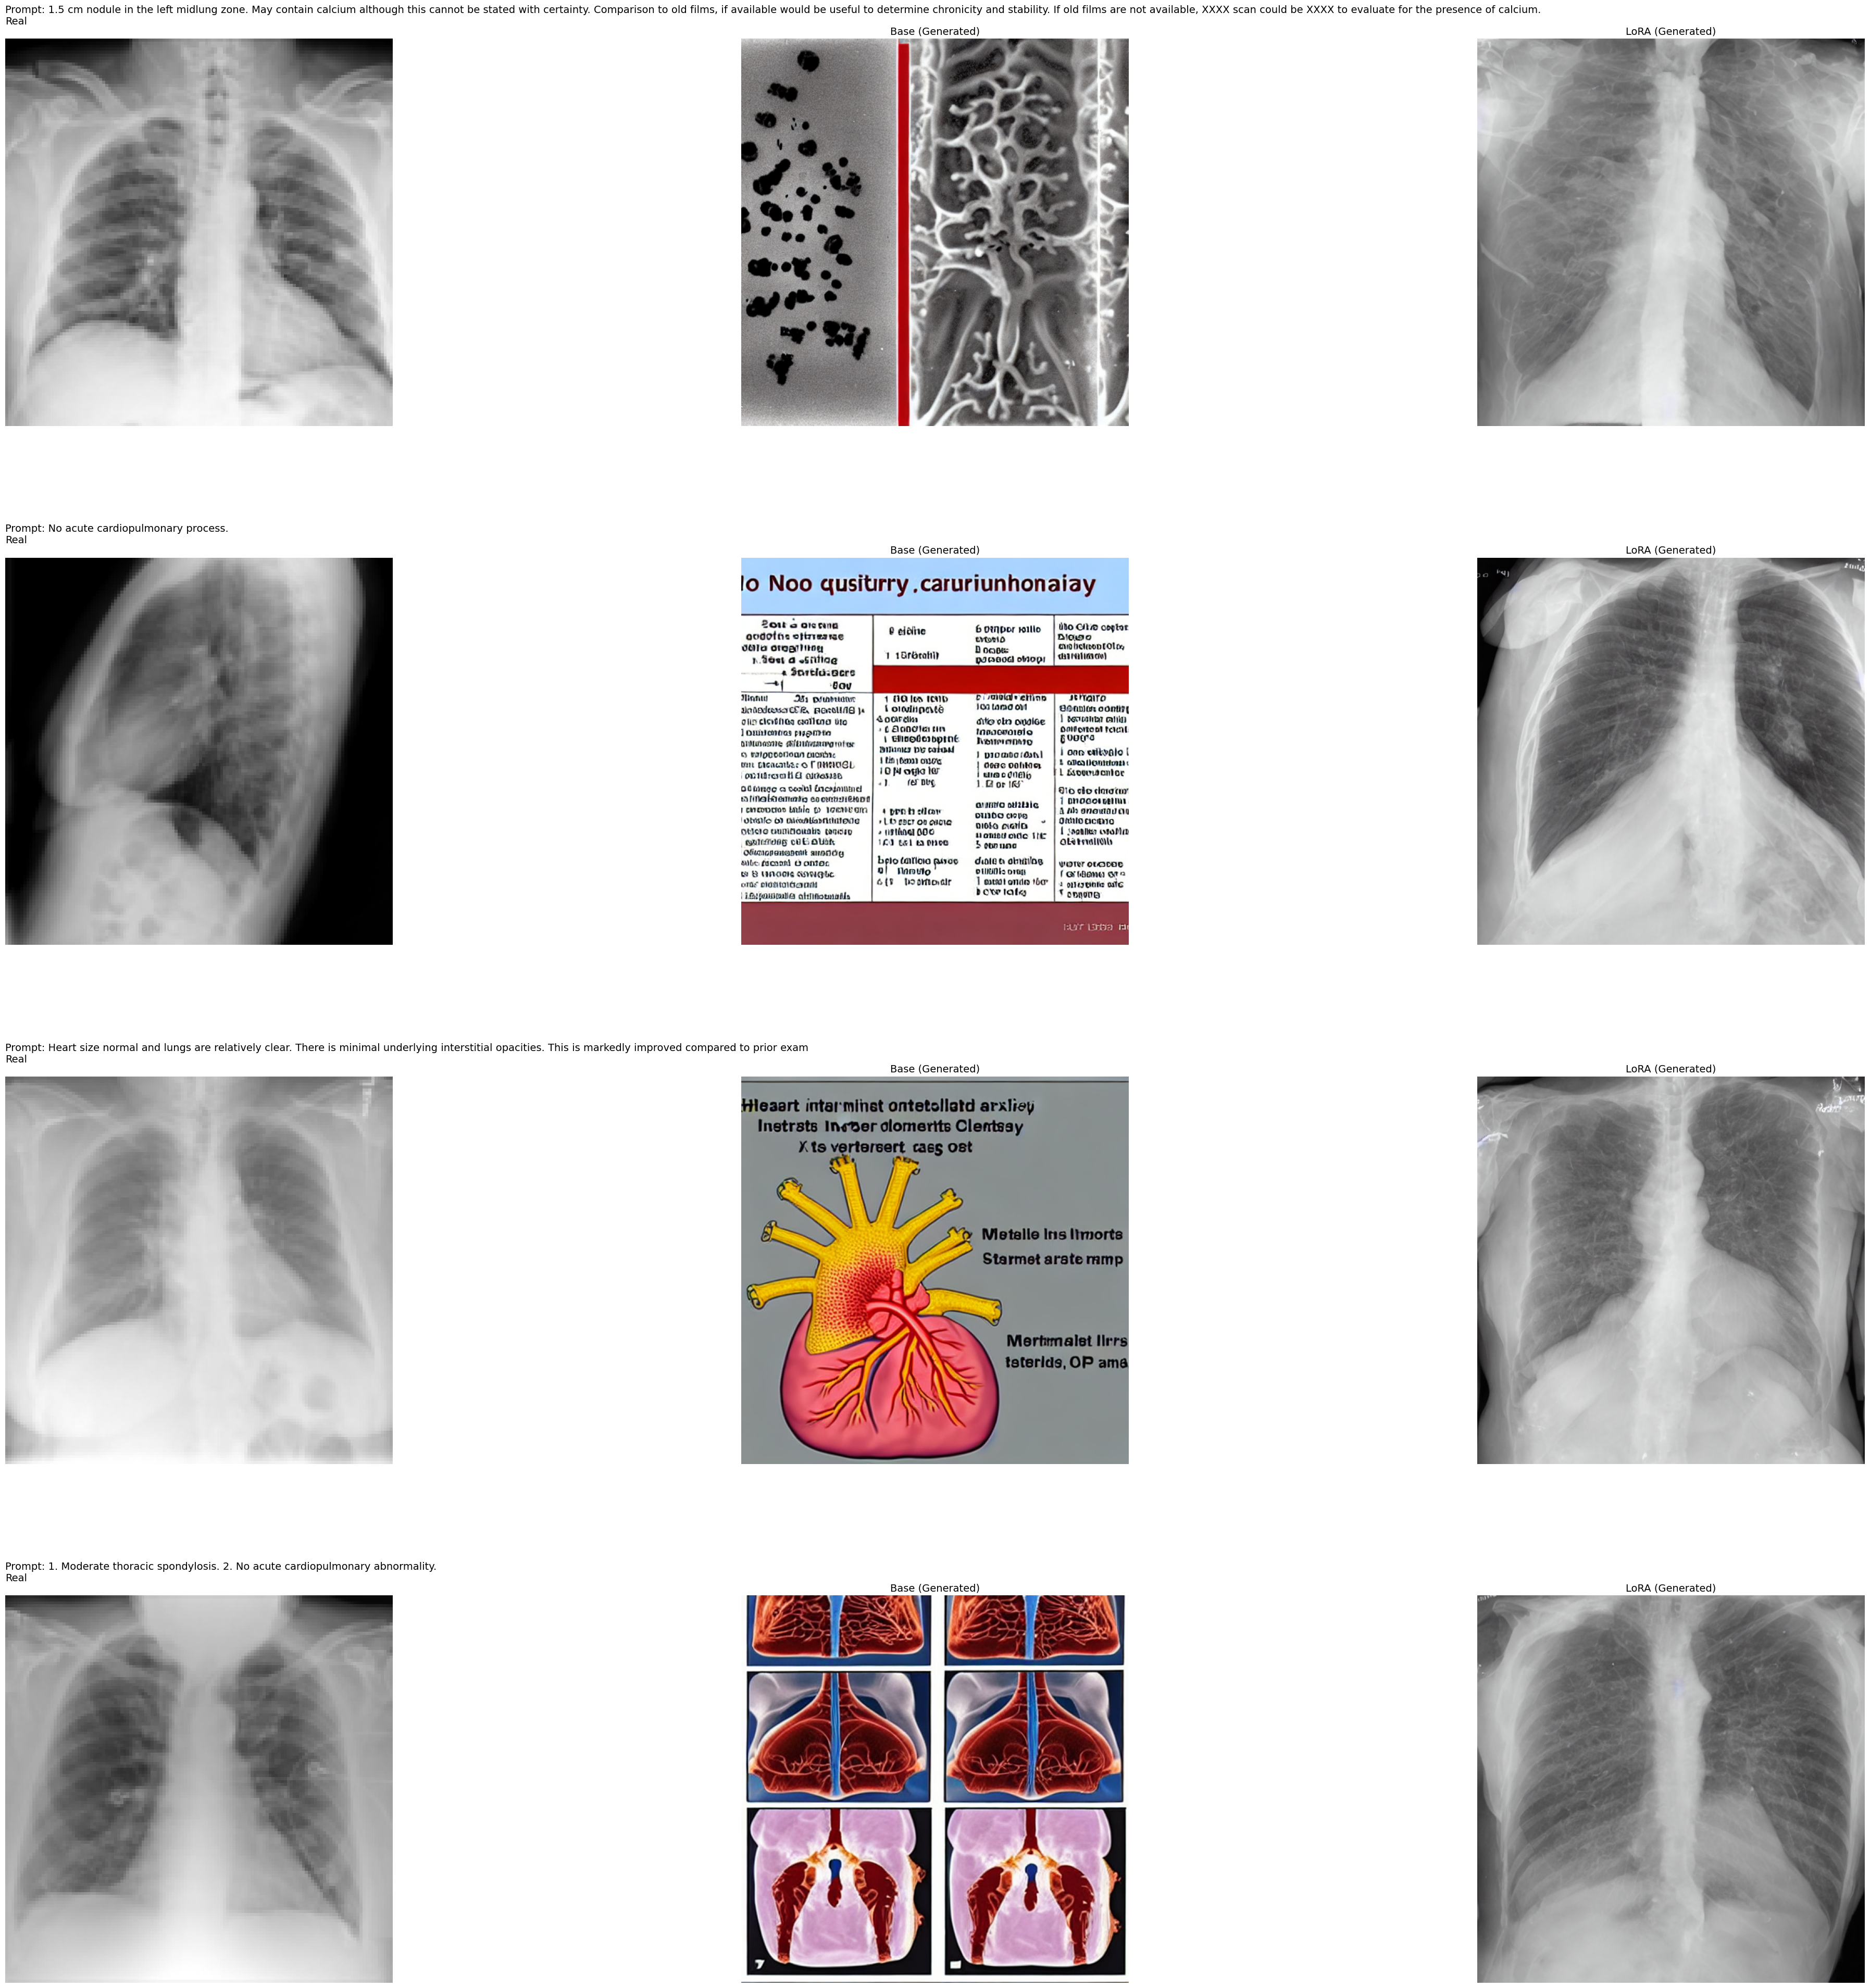

In [11]:
from PIL import Image
import torch
from transformers import CLIPTokenizer
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import numpy as np

# === Load base and LoRA pipelines ===
pipe_base = StableDiffusionPipeline.from_pretrained(
    pretrained_model,
    torch_dtype=torch.float16,
).to("cuda")
pipe_base.safety_checker = None
pipe_base.unet.eval()
pipe_base.vae.eval()
pipe_base.text_encoder.eval()

pipe_lora = StableDiffusionPipeline.from_pretrained(
    pretrained_model,
    torch_dtype=torch.float16,
).to("cuda")
pipe_lora.safety_checker = None
pipe_lora.unet.load_attn_procs(output_dir)
pipe_lora.unet.eval()
pipe_lora.vae.eval()
pipe_lora.text_encoder.eval()

# === Select a small batch from test set ===
batch = next(iter(test_dataloader))
pixel_values = batch["pixel_values"].to("cuda")
prompts = batch["raw_texts"]  # directly use raw text

# === Generate images with both models ===
with torch.no_grad():
    generated_base_images = pipe_base(prompts, num_inference_steps=50, height=512, width=512).images
    generated_lora_images = pipe_lora(prompts, num_inference_steps=50, height=512, width=512).images

# === Convert real images to PIL ===
def tensor_to_pil(tensor):
    tensor = tensor.detach().cpu().clamp(-1, 1)
    tensor = (tensor + 1) / 2  # scale to [0,1]
    np_img = tensor.permute(1, 2, 0).numpy()
    return Image.fromarray((np_img * 255).astype(np.uint8))

real_images = [tensor_to_pil(img) for img in pixel_values]

# === Display real, base, and LoRA images side by side ===
n = min(4, len(real_images))
plt.figure(figsize=(36, 10 * n))

for i in range(n):
    # Real Image
    plt.subplot(n, 3, 3 * i + 1)
    plt.axis("off")
    plt.title(f"Prompt: {prompts[i]}\nReal", fontsize=14, loc='left', pad=20)
    plt.imshow(real_images[i])

    # Base Model Generated Image
    plt.subplot(n, 3, 3 * i + 2)
    plt.axis("off")
    plt.title("Base (Generated)", fontsize=14)
    plt.imshow(generated_base_images[i])

    # LoRA Model Generated Image
    plt.subplot(n, 3, 3 * i + 3)
    plt.axis("off")
    plt.title("LoRA (Generated)", fontsize=14)
    plt.imshow(generated_lora_images[i])

plt.tight_layout()
plt.show()


In [10]:
from accelerate import Accelerator
from torchvision import transforms
from transformers import CLIPTokenizer
from diffusers import StableDiffusionPipeline
from torchmetrics.image.fid import FrechetInceptionDistance
import torch
from tqdm import tqdm
import gc

from diffusers import StableDiffusionPipeline
from torch.utils.data import DataLoader
import torch
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
from torchmetrics.image.fid import FrechetInceptionDistance

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/loaders/unet.py:212: FutureWarning: `load_attn_procs` is deprecated and will be removed in version 0.40.0. Using the `load_attn_procs()` method has been deprecated and will be removed in a future version. Please use `load_lora_adapter()`.
  deprecate("load_attn_procs", "0.40.0", deprecation_message)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

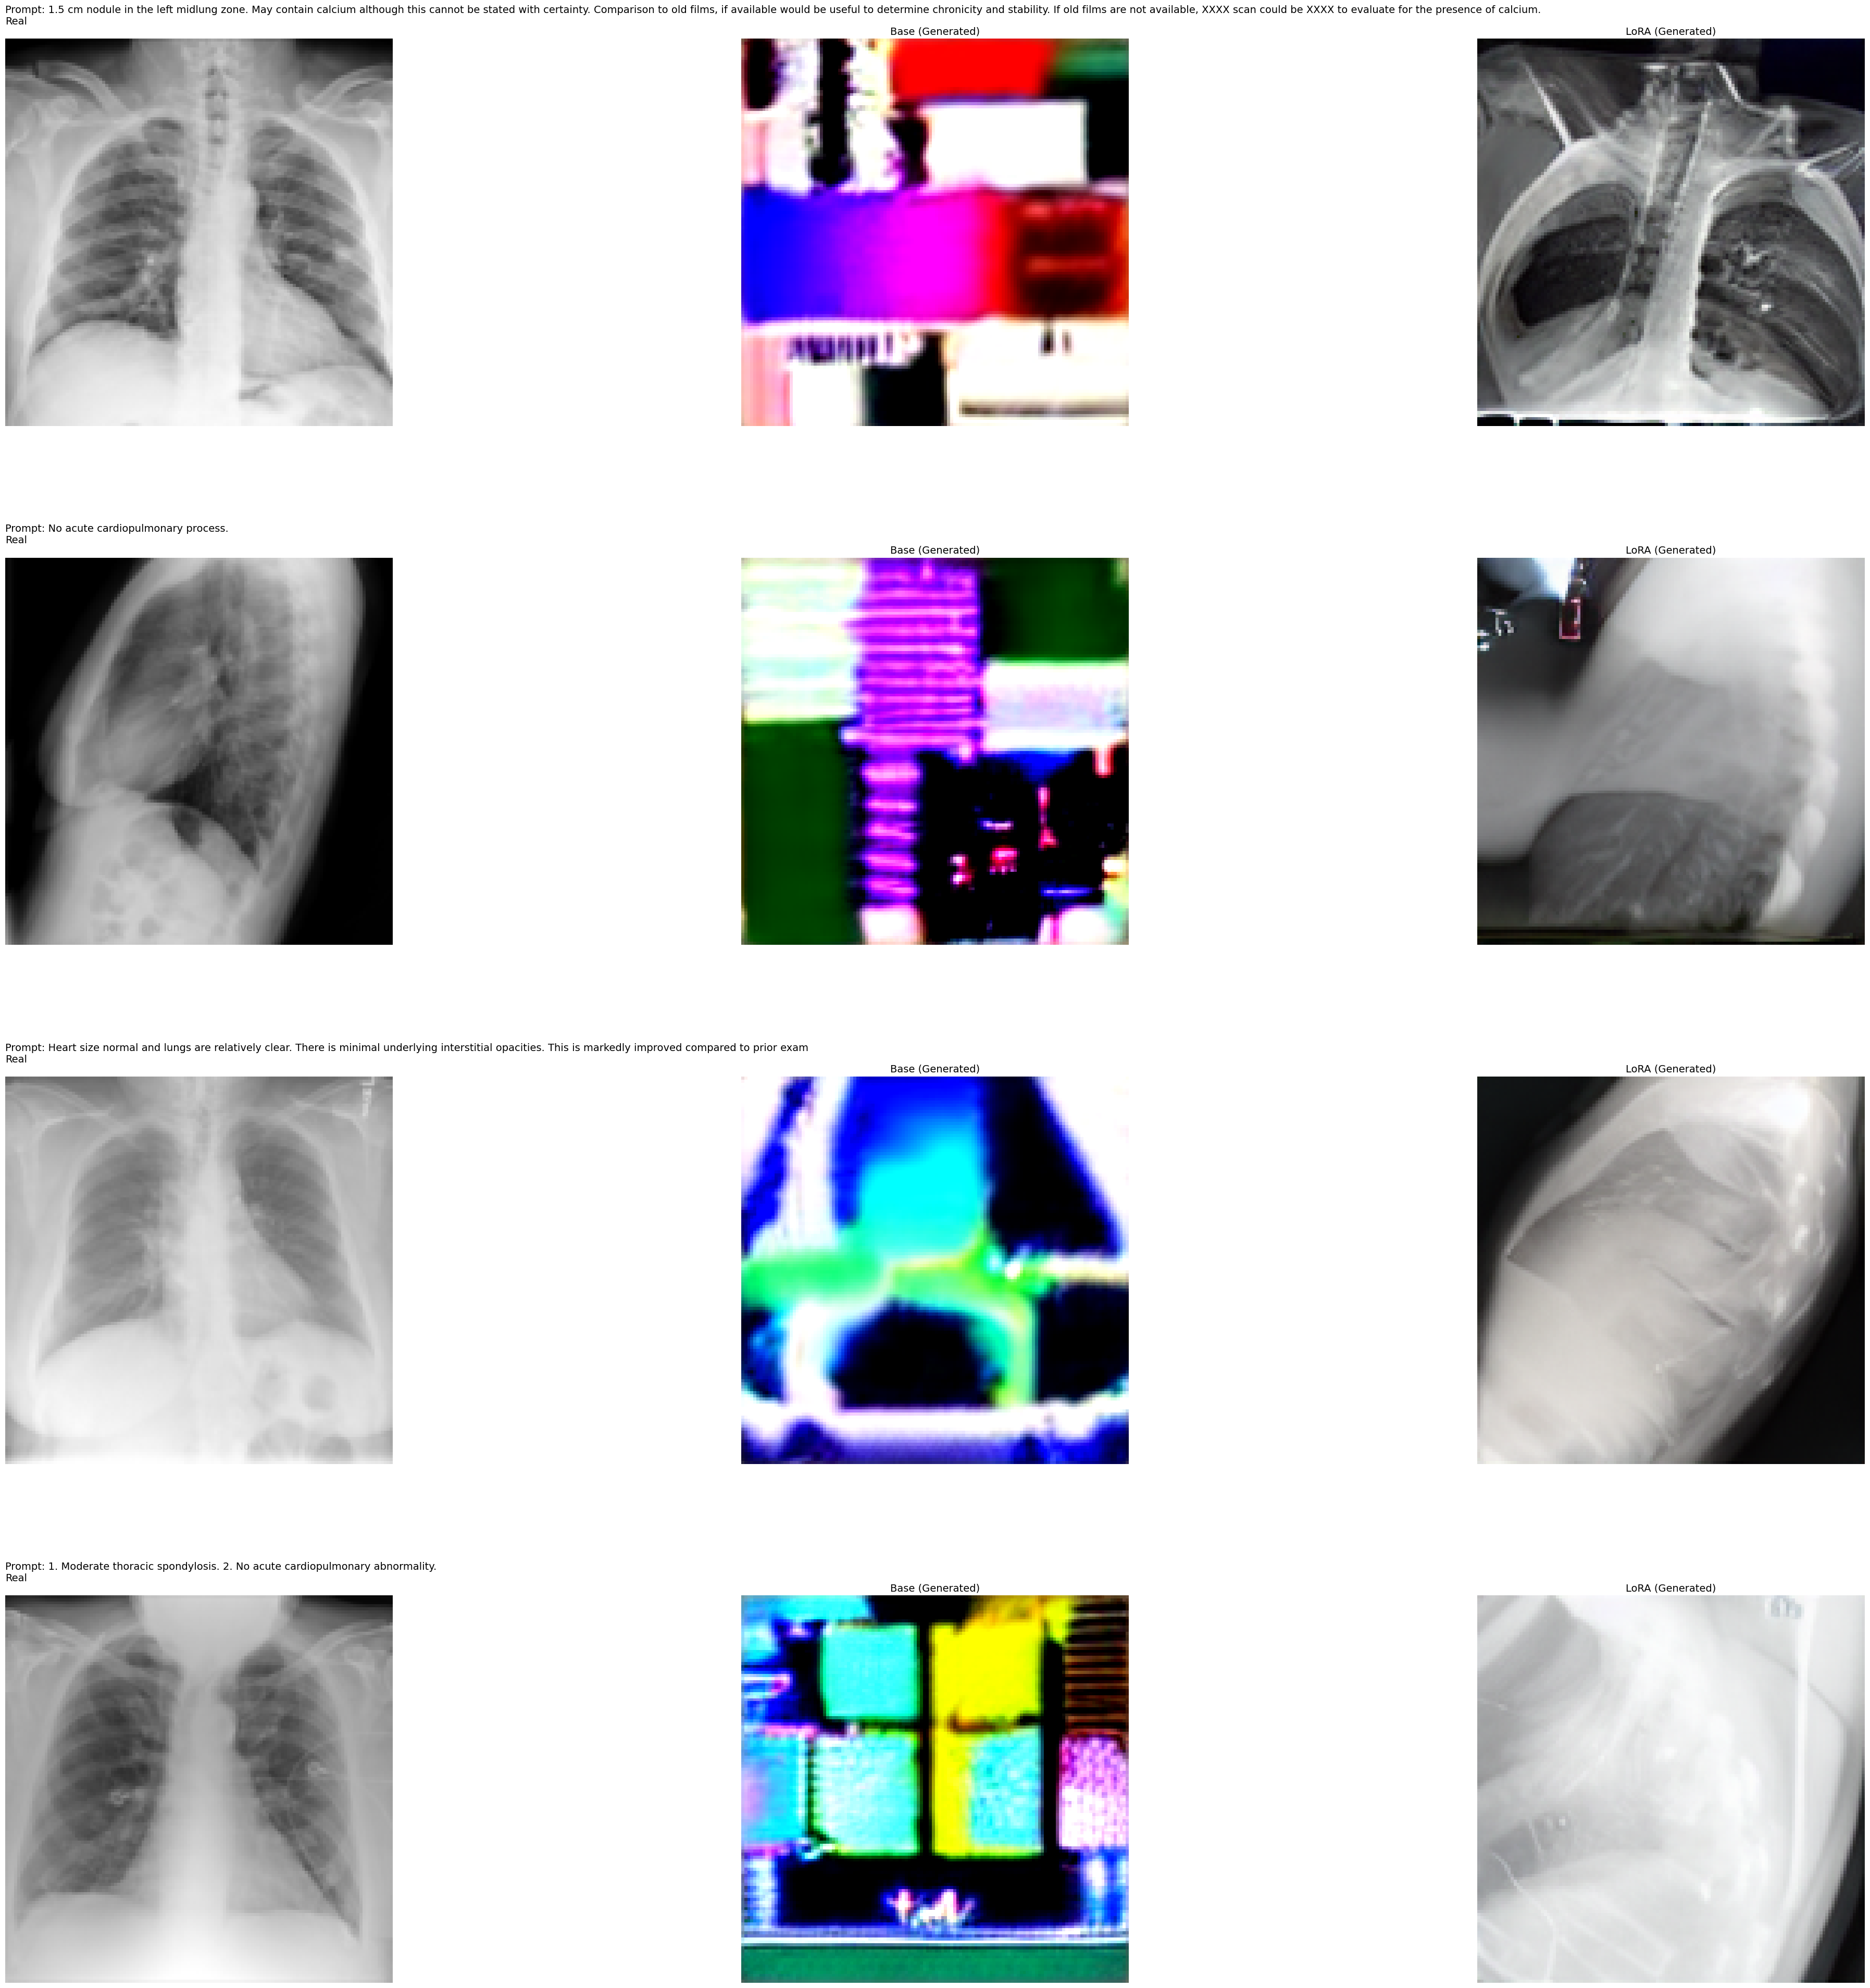

In [11]:
from PIL import Image
import torch
from transformers import CLIPTokenizer
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import numpy as np

# === Load base and LoRA pipelines ===
pipe_base = StableDiffusionPipeline.from_pretrained(
    pretrained_model,
    torch_dtype=torch.float16,
).to("cuda")
pipe_base.safety_checker = None
pipe_base.unet.eval()
pipe_base.vae.eval()
pipe_base.text_encoder.eval()

pipe_lora = StableDiffusionPipeline.from_pretrained(
    pretrained_model,
    torch_dtype=torch.float16,
).to("cuda")
pipe_lora.safety_checker = None
pipe_lora.unet.load_attn_procs(output_dir)
pipe_lora.unet.eval()
pipe_lora.vae.eval()
pipe_lora.text_encoder.eval()

# === Select a small batch from test set ===
batch = next(iter(test_dataloader))
pixel_values = batch["pixel_values"].to("cuda")
prompts = batch["raw_texts"]  # directly use raw text

# === Generate images with both models ===
with torch.no_grad():
    generated_base_images = pipe_base(prompts, num_inference_steps=50, height=128, width=128).images
    generated_lora_images = pipe_lora(prompts, num_inference_steps=50, height=128, width=128).images

# === Convert real images to PIL ===
def tensor_to_pil(tensor):
    tensor = tensor.detach().cpu().clamp(-1, 1)
    tensor = (tensor + 1) / 2  # scale to [0,1]
    np_img = tensor.permute(1, 2, 0).numpy()
    return Image.fromarray((np_img * 255).astype(np.uint8))

real_images = [tensor_to_pil(img) for img in pixel_values]

# === Display real, base, and LoRA images side by side ===
n = min(4, len(real_images))
plt.figure(figsize=(36, 10 * n))

for i in range(n):
    # Real Image
    plt.subplot(n, 3, 3 * i + 1)
    plt.axis("off")
    plt.title(f"Prompt: {prompts[i]}\nReal", fontsize=14, loc='left', pad=20)
    plt.imshow(real_images[i])

    # Base Model Generated Image
    plt.subplot(n, 3, 3 * i + 2)
    plt.axis("off")
    plt.title("Base (Generated)", fontsize=14)
    plt.imshow(generated_base_images[i])

    # LoRA Model Generated Image
    plt.subplot(n, 3, 3 * i + 3)
    plt.axis("off")
    plt.title("LoRA (Generated)", fontsize=14)
    plt.imshow(generated_lora_images[i])

plt.tight_layout()
plt.show()



In [15]:
from diffusers import StableDiffusionPipeline
from torch.utils.data import DataLoader
import torch
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
from torchmetrics.image.fid import FrechetInceptionDistance
from accelerate import Accelerator
import gc
from itertools import islice

# === Initialize Accelerator and Device ===
accelerator = Accelerator()
device = accelerator.device

# === Image Transform for Inception (Resize to 299x299) ===
fid_transform = transforms.Compose([
    transforms.Resize((299, 299), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),  # converts to [0.0, 1.0]
])

# === Helper: Convert float image tensor to uint8 ===
def preprocess_for_fid(imgs: torch.Tensor):
    imgs = imgs.detach().cpu()
    if imgs.min() < 0:  # likely in [-1, 1], rescale to [0, 1]
        imgs = (imgs + 1) * 0.5
    imgs = imgs.clamp(0, 1)
    imgs = (imgs * 255).to(torch.uint8)
    return imgs

# === Function to collect real and generated image tensors ===
def generate_and_collect_fid(pipe, dataloader, use_half=True):
    real_images = []
    generated_images = []

    # Convert to list to get length if needed
    dataloader_iter = iter(dataloader)
    if use_half:
        total_batches = len(dataloader)
        half_batches = total_batches // 2
        dataloader_iter = islice(dataloader_iter, half_batches)

    for batch in tqdm(dataloader_iter, desc="Generating Images"):
        pixel_values = batch["pixel_values"].to(device)
        prompts = batch["raw_texts"]

        with torch.inference_mode(), torch.autocast(device_type="cuda"):
            images = pipe(prompts, num_inference_steps=50, height=128, width=128).images

        for i in range(len(images)):
            real_img_tensor = pixel_values[i].detach().cpu().clamp(-1, 1) * 0.5 + 0.5
            real_img = fid_transform(transforms.ToPILImage()(real_img_tensor))
            gen_img = fid_transform(images[i])
            real_images.append(real_img)
            generated_images.append(gen_img)

    real_images = preprocess_for_fid(torch.stack(real_images))
    generated_images = preprocess_for_fid(torch.stack(generated_images))
    return real_images, generated_images

# === Compute FID helper ===
def compute_fid_batched(real_images, generated_images, batch_size=32):
    fid_metric = FrechetInceptionDistance(feature=2048).to(device)

    # Split into batches to avoid OOM
    for i in range(0, len(real_images), batch_size):
        real_batch = real_images[i:i+batch_size].to(device)
        gen_batch = generated_images[i:i+batch_size].to(device)
        fid_metric.update(real_batch, real=True)
        fid_metric.update(gen_batch, real=False)

    fid_score = fid_metric.compute().item()
    return fid_score

# === Paths to cache ===
real_path = "/kaggle/working/real_imgs.pt"
base_path = "/kaggle/working/gen_base_imgs.pt"
lora_path = "/kaggle/working/gen_lora_imgs.pt"



# === Load and Evaluate Base Model ===

# === Load or generate real + base images ===
if os.path.exists(real_path) and os.path.exists(base_path):
    print("Loading cached real/base images...")
    real_imgs = torch.load(real_path)
    gen_base_imgs = torch.load(base_path)
else:
    print("Generating real/base images...")

pipe_base = StableDiffusionPipeline.from_pretrained(
    pretrained_model, torch_dtype=torch.float16
).to(device)
pipe_base.safety_checker = lambda images, clip_input: (images, [False] * len(images))

real_imgs, gen_base_imgs = generate_and_collect_fid(pipe_base, test_dataloader)
torch.save(real_imgs, real_path)
torch.save(gen_base_imgs, base_path)

del pipe_base
torch.cuda.empty_cache()
gc.collect()

fid_score_base = compute_fid_batched(real_imgs, gen_base_imgs)
print(f"FID (Base Model): {fid_score_base:.4f}")

# === Load and Evaluate LoRA Model ===
if os.path.exists(lora_path):
    print("Loading cached LoRA images...")
    gen_lora_imgs = torch.load(lora_path)
else:
    print("Generating LoRA images...")

pipe_lora = StableDiffusionPipeline.from_pretrained(
    pretrained_model, torch_dtype=torch.float16
).to(device)
pipe_lora.unet.load_attn_procs(output_dir)
pipe_lora.safety_checker = lambda images, clip_input: (images, [False] * len(images))

_, gen_lora_imgs = generate_and_collect_fid(pipe_lora, test_dataloader)

torch.save(gen_lora_imgs, lora_path)

del pipe_lora
torch.cuda.empty_cache()
gc.collect()

fid_score_lora = compute_fid_batched(real_imgs, gen_lora_imgs)
print(f"FID (LoRA Model): {fid_score_lora:.4f}")


Generating real/base images...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating Images: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 1it [00:06,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 2it [00:12,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 3it [00:18,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 4it [00:24,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 5it [00:30,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 6it [00:36,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 7it [00:42,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 8it [00:48,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 9it [00:54,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 10it [01:00,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 11it [01:06,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 12it [01:12,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 13it [01:18,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 14it [01:24,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 15it [01:30,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 16it [01:36,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 17it [01:42,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 18it [01:48,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 19it [01:54,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 20it [02:00,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 21it [02:06,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 22it [02:12,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 23it [02:18,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 24it [02:24,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 25it [02:30,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 26it [02:36,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 27it [02:42,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 28it [02:48,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 29it [02:54,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 30it [03:00,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 31it [03:06,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 32it [03:12,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 33it [03:18,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 34it [03:24,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 35it [03:30,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 36it [03:36,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 37it [03:42,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 38it [03:48,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 39it [03:54,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 40it [04:00,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 41it [04:06,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 42it [04:12,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 43it [04:18,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 44it [04:24,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 45it [04:30,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 46it [04:36,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 47it [04:42,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 48it [04:48,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 49it [04:54,  6.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 50it [05:00,  6.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 51it [05:06,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 52it [05:12,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 53it [05:18,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 54it [05:24,  6.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 55it [05:30,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 56it [05:36,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 57it [05:42,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 58it [05:48,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 59it [05:54,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 60it [06:00,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 61it [06:06,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 62it [06:12,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 63it [06:18,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 64it [06:24,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 65it [06:30,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 66it [06:36,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 67it [06:42,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 68it [06:48,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 69it [06:55,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 70it [07:01,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 71it [07:07,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 72it [07:13,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 73it [07:19,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 74it [07:25,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 75it [07:31,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 76it [07:37,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 77it [07:43,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 78it [07:49,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 79it [07:55,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 80it [08:01,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 81it [08:07,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 82it [08:13,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 83it [08:19,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 84it [08:25,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 85it [08:31,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 86it [08:37,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 87it [08:43,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 88it [08:49,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 89it [08:55,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 90it [09:01,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 91it [09:07,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 92it [09:13,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 93it [09:19,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 94it [09:25,  6.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 95it [09:31,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 96it [09:37,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 97it [09:43,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 98it [09:49,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 99it [09:55,  6.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 100it [10:01,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 101it [10:07,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 102it [10:13,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 103it [10:19,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 104it [10:25,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 105it [10:31,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 106it [10:37,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 107it [10:43,  6.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 108it [10:49,  6.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 109it [10:55,  6.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 110it [11:01,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 111it [11:07,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 112it [11:13,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 113it [11:19,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 114it [11:25,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 115it [11:31,  6.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 116it [11:37,  6.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 117it [11:43,  6.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 118it [11:49,  6.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 119it [11:56,  6.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 120it [12:02,  6.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 121it [12:08,  6.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 122it [12:14,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 123it [12:20,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 124it [12:26,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 125it [12:32,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 126it [12:38,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 127it [12:44,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 128it [12:50,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 129it [12:56,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 130it [13:02,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 131it [13:08,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 132it [13:14,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 133it [13:20,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 134it [13:26,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 135it [13:32,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 136it [13:38,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 137it [13:44,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 138it [13:50,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 139it [13:56,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 140it [14:02,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 141it [14:08,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 142it [14:14,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 143it [14:20,  6.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 144it [14:26,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 145it [14:32,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 146it [14:38,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 147it [14:44,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 148it [14:50,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 149it [14:56,  6.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 150it [15:02,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 151it [15:09,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 152it [15:15,  6.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 153it [15:21,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 154it [15:27,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 155it [15:33,  6.06s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 156it [15:39,  6.06s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 157it [15:45,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 158it [15:51,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 159it [15:57,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 160it [16:03,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 161it [16:09,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 162it [16:15,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 163it [16:21,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 164it [16:27,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 165it [16:33,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 166it [16:39,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 167it [16:45,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 168it [16:51,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 169it [16:57,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 170it [17:03,  6.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 171it [17:10,  6.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 172it [17:16,  6.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 173it [17:22,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 174it [17:28,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 175it [17:34,  6.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 176it [17:40,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 177it [17:46,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 178it [17:52,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 179it [17:58,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 180it [18:04,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 181it [18:10,  6.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 182it [18:16,  6.02s/it]


FID (Base Model): 363.9052
Generating LoRA images...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/loaders/unet.py:212: FutureWarning: `load_attn_procs` is deprecated and will be removed in version 0.40.0. Using the `load_attn_procs()` method has been deprecated and will be removed in a future version. Please use `load_lora_adapter()`.
  deprecate("load_attn_procs", "0.40.0", deprecation_message)
Generating Images: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 1it [00:06,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 2it [00:12,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 3it [00:19,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 4it [00:25,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 5it [00:31,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 6it [00:37,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 7it [00:44,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 8it [00:50,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 9it [00:57,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 10it [01:03,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 11it [01:09,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 12it [01:16,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 13it [01:22,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 14it [01:28,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 15it [01:35,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 16it [01:41,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 17it [01:47,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 18it [01:54,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 19it [02:00,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 20it [02:06,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 21it [02:13,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 22it [02:19,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 23it [02:25,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 24it [02:32,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 25it [02:38,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 26it [02:44,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 27it [02:50,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 28it [02:57,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 29it [03:03,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 30it [03:09,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 31it [03:16,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 32it [03:22,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 33it [03:28,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 34it [03:35,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 35it [03:41,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 36it [03:47,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 37it [03:54,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 38it [04:00,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 39it [04:06,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 40it [04:13,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 41it [04:19,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 42it [04:25,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 43it [04:32,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 44it [04:38,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 45it [04:44,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 46it [04:51,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 47it [04:57,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 48it [05:03,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 49it [05:10,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 50it [05:16,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 51it [05:22,  6.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 52it [05:28,  6.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 53it [05:35,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 54it [05:41,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 55it [05:47,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 56it [05:54,  6.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 57it [06:00,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 58it [06:06,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 59it [06:13,  6.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 60it [06:19,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 61it [06:25,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 62it [06:32,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 63it [06:38,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 64it [06:44,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 65it [06:51,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 66it [06:57,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 67it [07:03,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 68it [07:10,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 69it [07:16,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 70it [07:22,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 71it [07:29,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 72it [07:35,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 73it [07:41,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 74it [07:47,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 75it [07:54,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 76it [08:00,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 77it [08:06,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 78it [08:13,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 79it [08:19,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 80it [08:25,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 81it [08:32,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 82it [08:38,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 83it [08:44,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 84it [08:51,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 85it [08:57,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 86it [09:03,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 87it [09:10,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 88it [09:16,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 89it [09:22,  6.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 90it [09:29,  6.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 91it [09:35,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 92it [09:41,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 93it [09:47,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 94it [09:54,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 95it [10:00,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 96it [10:06,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 97it [10:13,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 98it [10:19,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 99it [10:25,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 100it [10:32,  6.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 101it [10:38,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 102it [10:45,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 103it [10:51,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 104it [10:57,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 105it [11:04,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 106it [11:10,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 107it [11:16,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 108it [11:22,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 109it [11:29,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 110it [11:35,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 111it [11:41,  6.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 112it [11:48,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 113it [11:54,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 114it [12:00,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 115it [12:07,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 116it [12:13,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 117it [12:19,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 118it [12:26,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 119it [12:32,  6.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 120it [12:38,  6.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 121it [12:45,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 122it [12:51,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 123it [12:57,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 124it [13:04,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 125it [13:10,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 126it [13:16,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 127it [13:23,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 128it [13:29,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 129it [13:35,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 130it [13:42,  6.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 131it [13:48,  6.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 132it [13:55,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 133it [14:01,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 134it [14:07,  6.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 135it [14:14,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 136it [14:20,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 137it [14:26,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 138it [14:33,  6.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 139it [14:39,  6.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 140it [14:45,  6.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 141it [14:52,  6.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 142it [14:58,  6.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 143it [15:04,  6.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 144it [15:11,  6.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 145it [15:17,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 146it [15:23,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 147it [15:30,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 148it [15:36,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 149it [15:42,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 150it [15:49,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 151it [15:55,  6.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 152it [16:01,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 153it [16:08,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 154it [16:14,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 155it [16:20,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 156it [16:27,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 157it [16:33,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 158it [16:39,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 159it [16:46,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 160it [16:52,  6.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 161it [16:58,  6.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 162it [17:05,  6.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 163it [17:11,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 164it [17:17,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 165it [17:24,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 166it [17:30,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 167it [17:36,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 168it [17:43,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 169it [17:49,  6.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 170it [17:55,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 171it [18:02,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 172it [18:08,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 173it [18:14,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 174it [18:21,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 175it [18:27,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 176it [18:33,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 177it [18:40,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 178it [18:46,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 179it [18:52,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 180it [18:59,  6.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 181it [19:05,  6.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 182it [19:12,  6.33s/it]


FID (LoRA Model): 166.5497


In [16]:
from torchmetrics.image.inception import InceptionScore

# === Load saved generated images ===
gen_base_imgs = torch.load("/kaggle/working/gen_base_imgs.pt")
gen_lora_imgs = torch.load("/kaggle/working/gen_lora_imgs.pt")

# === Normalize to [0,1] and convert to float
gen_base_imgs = gen_base_imgs.float() / 255.0
gen_lora_imgs = gen_lora_imgs.float() / 255.0

# === IS Metric Initialization
is_metric = InceptionScore(normalize=True).to(device)  # normalize=True assumes [0,1] float

# === Compute IS for base model
is_metric.reset()
for i in range(0, len(gen_base_imgs), 32):
    batch = gen_base_imgs[i:i+32].to(device)
    is_metric.update(batch)
is_mean_base, is_std_base = is_metric.compute()
print(f"Inception Score (Base): {is_mean_base:.4f} ± {is_std_base:.4f}")

# === Compute IS for LoRA model
is_metric.reset()
for i in range(0, len(gen_lora_imgs), 32):
    batch = gen_lora_imgs[i:i+32].to(device)
    is_metric.update(batch)
is_mean_lora, is_std_lora = is_metric.compute()
print(f"Inception Score (LoRA): {is_mean_lora:.4f} ± {is_std_lora:.4f}")

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Inception Score (Base): 4.3015 ± 0.4088
Inception Score (LoRA): 3.9223 ± 0.3665
